In [1]:
import copy, getpass, queue, random, sys, time, tqdm
import numpy as np
import torch
from torchvision.transforms import *

sys.path.append('../..')
from DL.utils import *
from DL.networks import *
from DL.sqlite_data_loader import SQLDataLoader
from Database.DB_models import *

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
EMBEDDING_MODEL = '/home/lynx/pretrainedmodels/embedding_triplet_resnet50_1499/triplet_resnet50_1499.tar'
CROP_DIR = '/datadrive/missouricameratraps/crops_detector/'
DB_LIMIT = 2000

In [3]:
# Load the pretrained embedding model
checkpoint = load_checkpoint(EMBEDDING_MODEL)
if checkpoint['loss_type'].lower() == 'center' or checkpoint['loss_type'].lower() == 'softmax':
    embedding_net = SoftmaxNet(checkpoint['arch'], checkpoint['feat_dim'], False)
else:
    embedding_net = NormalizedEmbeddingNet(checkpoint['arch'], checkpoint['feat_dim'], False)
model = torch.nn.DataParallel(embedding_net).cuda()
model.load_state_dict(checkpoint['state_dict'])
model.eval()


DataParallel(
  (module): NormalizedEmbeddingNet(
    (inner_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (re

In [4]:
# Access the inner ResNet
model_inner_resnet = list(model.children())[0].inner_model


In [5]:
state_dict_copy = copy.deepcopy(model_inner_resnet.state_dict())
for k,v in state_dict_copy.items():
#     print(k)
    if 'bias' in k:
        tensor_size = v.cpu().numpy().shape
        new_tensor = torch.zeros_like(v)
        state_dict_copy[k].copy_(new_tensor)

    elif 'weight' in k:
        tensor_size = v.cpu().numpy().shape
        new_tensor = 0.1*torch.ones_like(v)
        state_dict_copy[k].copy_(new_tensor)

    elif 'mean' in k:
        tensor_size = v.cpu().numpy().shape
        new_tensor = torch.zeros_like(v)
        state_dict_copy[k].copy_(new_tensor)

    elif 'var' in k:
        tensor_size = v.cpu().numpy().shape
        new_tensor = torch.ones_like(v)
        state_dict_copy[k].copy_(new_tensor)

    else:
        print(k)

    

bn1.num_batches_tracked
layer1.0.bn1.num_batches_tracked
layer1.0.bn2.num_batches_tracked
layer1.0.bn3.num_batches_tracked
layer1.0.downsample.1.num_batches_tracked
layer1.1.bn1.num_batches_tracked
layer1.1.bn2.num_batches_tracked
layer1.1.bn3.num_batches_tracked
layer1.2.bn1.num_batches_tracked
layer1.2.bn2.num_batches_tracked
layer1.2.bn3.num_batches_tracked
layer2.0.bn1.num_batches_tracked
layer2.0.bn2.num_batches_tracked
layer2.0.bn3.num_batches_tracked
layer2.0.downsample.1.num_batches_tracked
layer2.1.bn1.num_batches_tracked
layer2.1.bn2.num_batches_tracked
layer2.1.bn3.num_batches_tracked
layer2.2.bn1.num_batches_tracked
layer2.2.bn2.num_batches_tracked
layer2.2.bn3.num_batches_tracked
layer2.3.bn1.num_batches_tracked
layer2.3.bn2.num_batches_tracked
layer2.3.bn3.num_batches_tracked
layer3.0.bn1.num_batches_tracked
layer3.0.bn2.num_batches_tracked
layer3.0.bn3.num_batches_tracked
layer3.0.downsample.1.num_batches_tracked
layer3.1.bn1.num_batches_tracked
layer3.1.bn2.num_batches_

In [6]:
model_inner_resnet.load_state_dict(state_dict_copy)
model.eval()


DataParallel(
  (module): NormalizedEmbeddingNet(
    (inner_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (re

In [7]:
def get_layer_outputs_by_forward_hook(model, model_layer, pixelx, pixely):
    # Create a hook function to store layer outputs
    layer_outputs = []
    def hook_function(module, input, output):
        layer_outputs.append(output)
    
    # Register the hook
    hook_handle = model_layer.register_forward_hook(hook_function)
    
    # Get output of layer for input samples
    blank_img_tensor = torch.zeros([3,224,224])
    blank_img_tensor[:, pixelx, pixely] = 1
    output = model.forward(blank_img_tensor.unsqueeze(0))
    
    # Deregister the hook
    hook_handle.remove()
    
    return layer_outputs

In [77]:
channel_no = 0
pixelx = 106
pixely = 106

In [78]:
l4b1conv1_outputs = get_layer_outputs_by_forward_hook(model, model_inner_resnet.layer3[3].conv1, pixelx, pixely)

/data/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


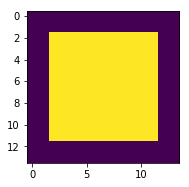

In [79]:
im_activation_maps = l4b1conv1_outputs[0]
im_channel_activation_map = im_activation_maps[0,channel_no,:,:].cpu().detach().numpy()
# print(im_channel_activation_map)
im_channel_activation_map[im_channel_activation_map>0]=1
plt.subplot(1,2,1)
blank_img_tensor = torch.zeros([3,224,224])
blank_img_tensor[:, pixelx, pixely] = 1
plt.subplot(1,2,1)
plt.imshow(im_channel_activation_map[:,:])

In [206]:
im_channel_activation_map[:,:].shape

(7, 7)

In [200]:
sum(im_channel_activation_map.flatten()>0)

196

In [201]:
sum(im_channel_activation_map.flatten()==0)

0

In [188]:
np.prod(im_channel_activation_map.shape)

3136